In [1]:
%load_ext autoreload
%autoreload 2

import collections
import cPickle as pickle
import lasagne
import mahotas as mh
import numpy as np
import os
import time

import sys
sys.path.append('../')
import gp

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/d/nolearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [22]:
image, prob, mask, gold, rhoana = gp.Util.read_section('/home/d/data/cylinderNEW/', 100)

Loading z00000100.png


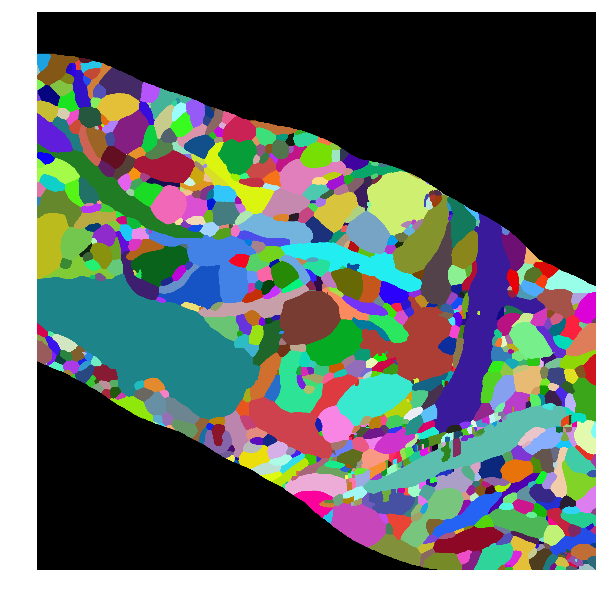

In [23]:
gp.Util.view(rhoana, color=True, large=True)

In [24]:
# we are working with label 600
label_value = rhoana[1250,1400]
print 'label', label_value
binary = gp.Util.threshold(rhoana, label_value)
bb = mh.bbox(binary)
bb = [bb[0]-40, bb[1]+40, bb[2]-40, bb[3]+40] # grab a little more since we dilate

label 600


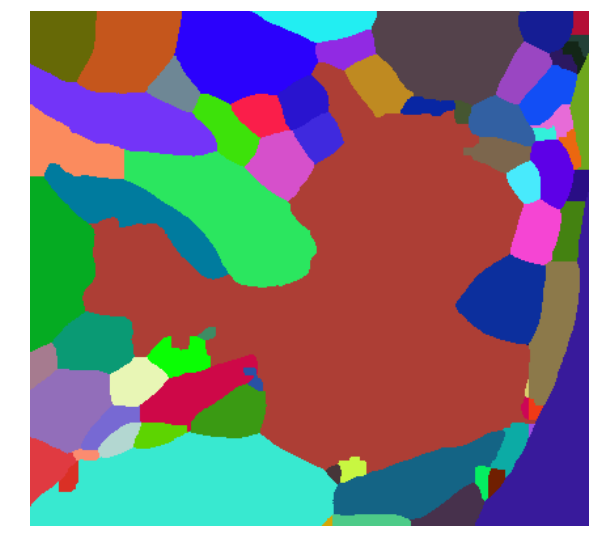

In [25]:
gp.Util.view(gp.Util.crop_by_bbox(rhoana, bb), color=True, large=True, file='/tmp/me_seg.png')

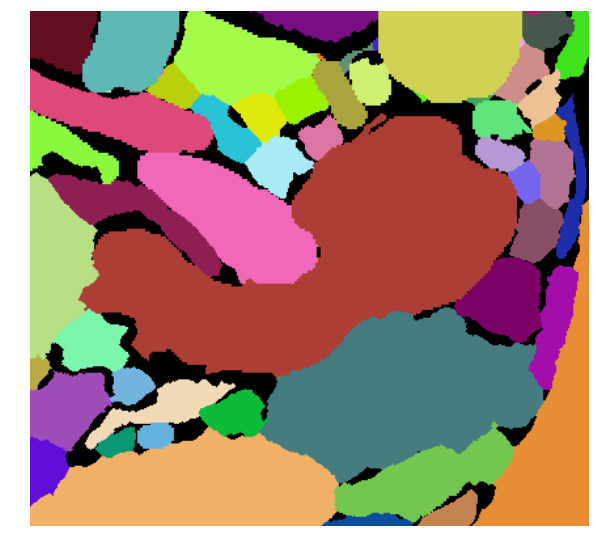

In [26]:
cropped_gold = gp.Util.crop_by_bbox(gold, bb)
cropped_gold[cropped_gold == cropped_gold[220,220]] = 600
gp.Util.view(cropped_gold, color=True, large=True, file='/tmp/me_gold.png')

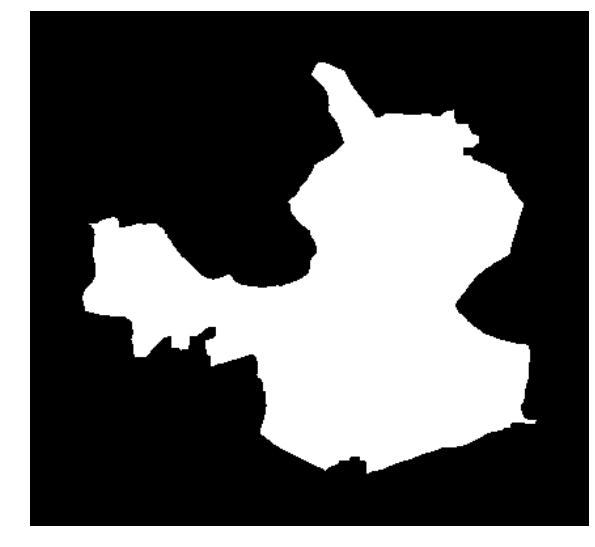

In [57]:
cropped_binary = gp.Util.crop_by_bbox(binary,bb)
gp.Util.view(cropped_binary.astype(np.uint8)*255, color=False, large=True, file='/tmp/me_binary.png')

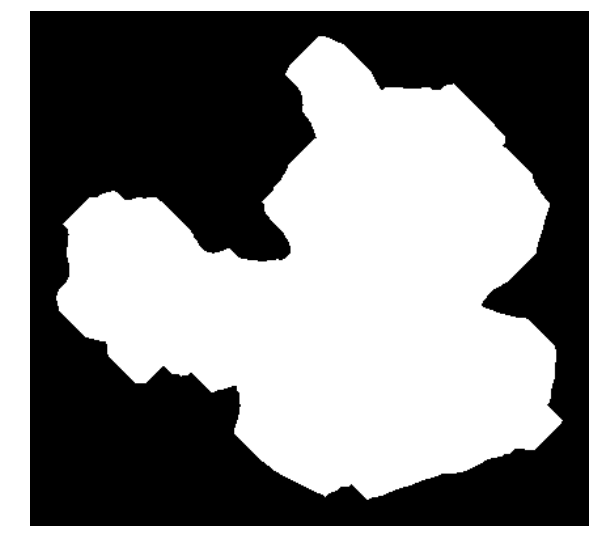

In [28]:
dilated_binary = np.array(cropped_binary, dtype=np.bool)
for i in range(20):
  dilated_binary = mh.dilate(dilated_binary)

gp.Util.view(dilated_binary, color=False, large=True, file='/tmp/me_dilated.png')

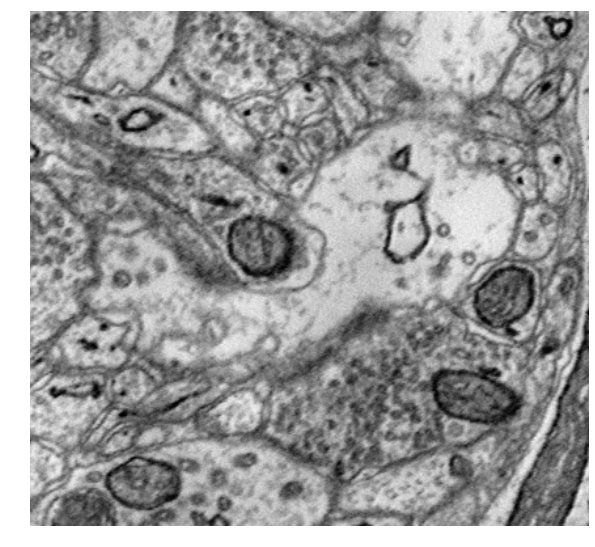

In [29]:
cropped_image = gp.Util.crop_by_bbox(image, bb)
gp.Util.view(cropped_image, color=False, large=True, file='/tmp/me_image.png')

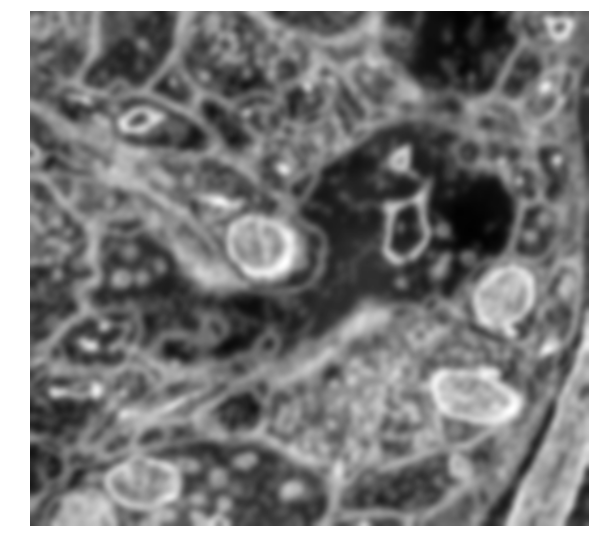

In [35]:
speed_image = gp.Legacy.invert(cropped_image)
gp.Util.view(speed_image, color=False, large=True, file='/tmp/me_inverted.png')

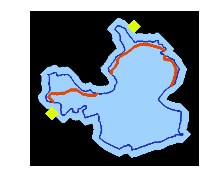

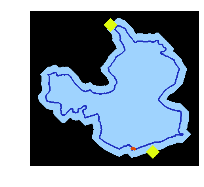

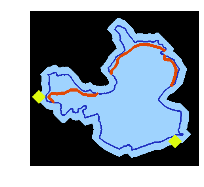

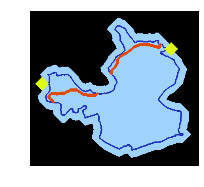

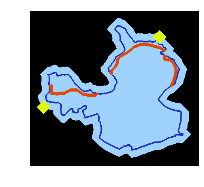

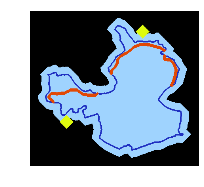

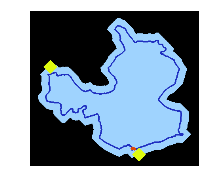

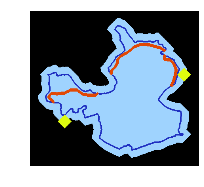

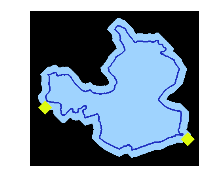

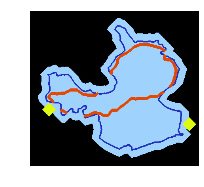

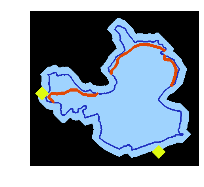

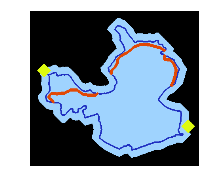

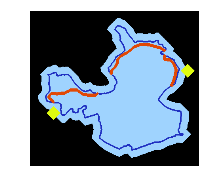

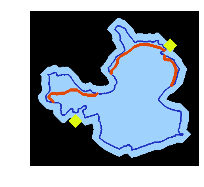

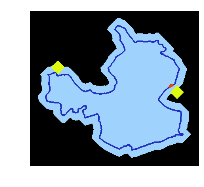

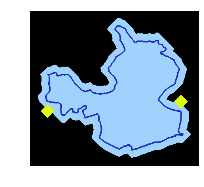

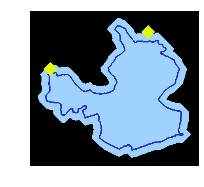

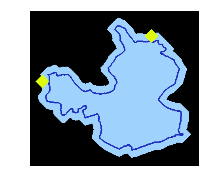

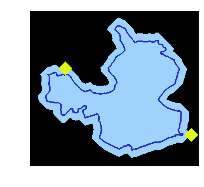

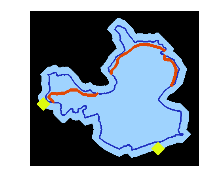

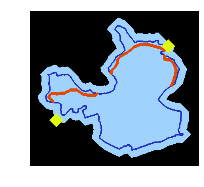

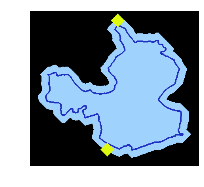

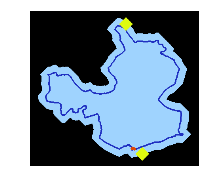

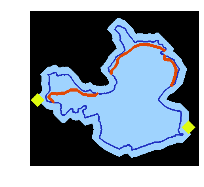

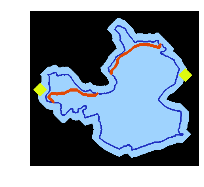

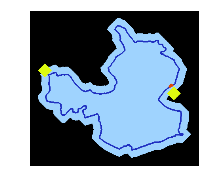

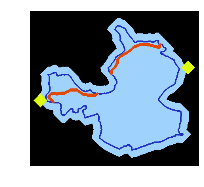

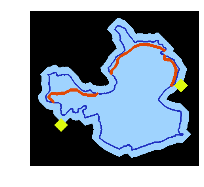

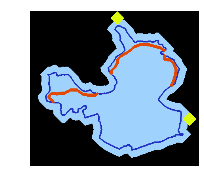

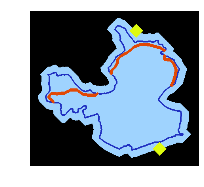

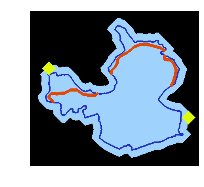

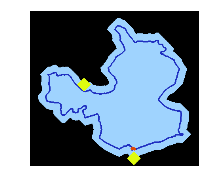

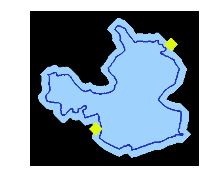

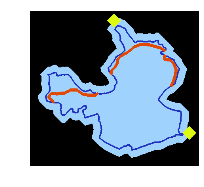

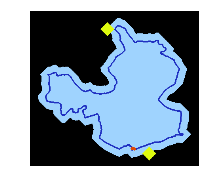

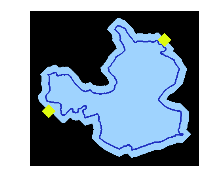

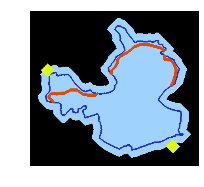

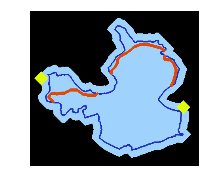

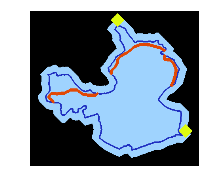

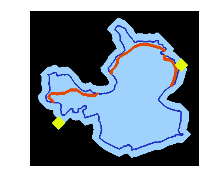

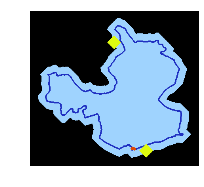

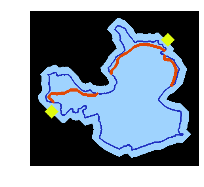

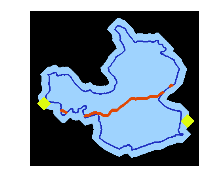

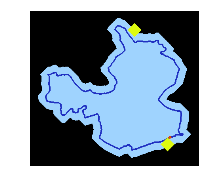

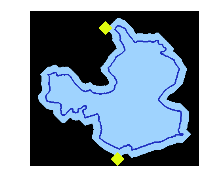

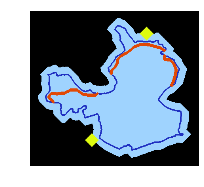

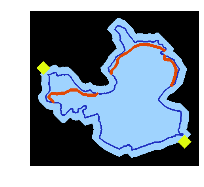

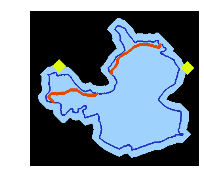

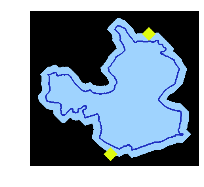

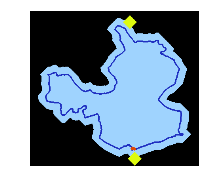

In [48]:
l_seeds = []
l_watersheds = []
l_borders = []
outputs = []

cropped_binary = gp.Util.crop_by_bbox(binary,bb)
for i in range(50):
    seeds, ws = gp.Legacy.random_watershed(dilated_binary, gp.Legacy.gradient(cropped_image), border_seeds=True, erode=False)

    output = np.array(dilated_binary).astype(np.uint8)
    
    ws_label1 = ws.max()
    ws_label2 = ws.max()-1
    border = mh.labeled.border(ws, ws_label1, ws_label2)
    border[cropped_binary == 0] = 0
    border = mh.dilate(border)
    border = mh.dilate(border)
    border = mh.dilate(border)

    orig_border = np.array(dilated_binary)
    orig_border[:] = 0
    orig_border[mh.labeled.border(cropped_binary,0,1) == 1] = 1
    orig_border = mh.dilate(orig_border)
    
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    seeds = mh.dilate(seeds)
    
    output[dilated_binary == 1] = 1

    output[orig_border == 1] = 2
    output[border == 1] = 888
    output[seeds != 0] = 11
    
    l_seeds.append(seeds)
    l_watersheds.append(ws)
    l_borders.append(border)
    
    outputs.append(output)
    gp.Util.view(output, large=False)

In [49]:
GOOD_RESULT = -8

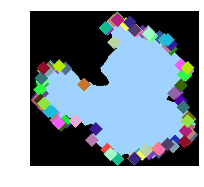

In [50]:
s_sum = np.zeros(l_seeds[0].shape)
s_sum[dilated_binary==1] = 1

for i,b in enumerate(l_seeds[0:50]):
    s_sum[b!=0] = i
    
gp.Util.view(s_sum.astype(np.uint8), color=True)

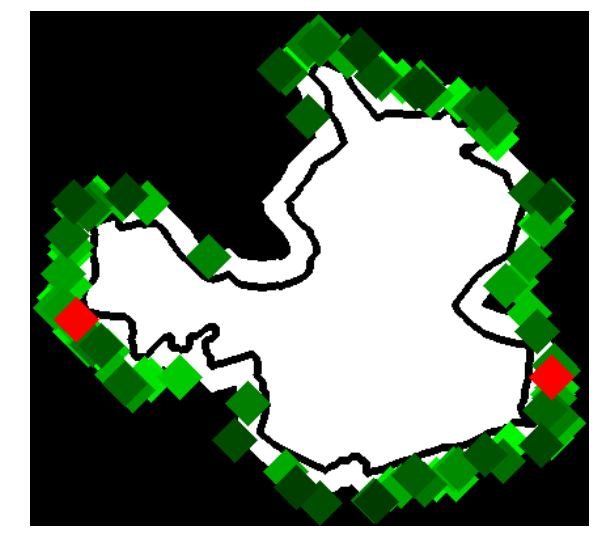

In [51]:
rgb_seeds = np.zeros((l_seeds[0].shape[0], l_seeds[0].shape[1], 3), dtype=np.uint8)
rgb_seeds[dilated_binary==1] = (255,255,255)
real_border = mh.labeled.border(cropped_binary,0,1)
real_border = mh.dilate(real_border)
real_border = mh.dilate(real_border)
rgb_seeds[real_border==1] = (0,0,0)

for i,b in enumerate(l_seeds[0:50]):
    rgb_seeds[b!=0] = (0,255-(i*4),0)


rgb_seeds[l_seeds[GOOD_RESULT]!=0] = (255,0,0)
gp.Util.view(rgb_seeds, color=False, large=True, file='/tmp/me_seeds.png')


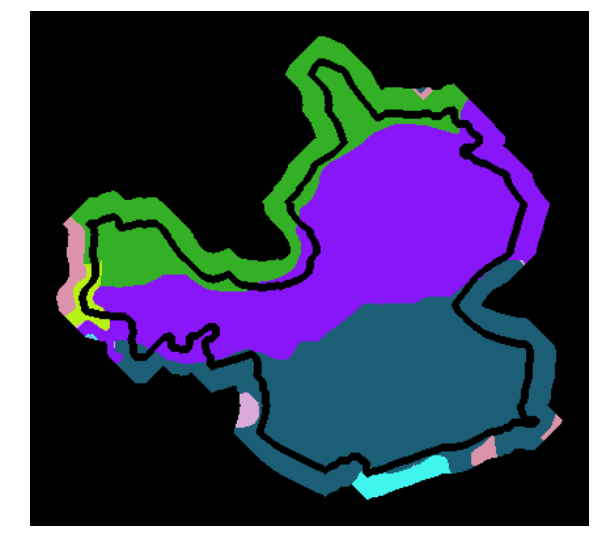

In [52]:
rgb_borders = np.zeros((l_seeds[0].shape[0], l_seeds[0].shape[1], 3), dtype=np.uint8)
rgb_borders[dilated_binary==1] = (255,255,255)
real_border = mh.labeled.border(cropped_binary,0,1)
real_border = mh.dilate(real_border)
real_border = mh.dilate(real_border)
rgb_borders[real_border==1] = (0,0,0)

borders_sum = np.zeros(l_seeds[0].shape, dtype=np.uint8)

for i,b in enumerate(l_watersheds[0:50]):
#     b_color = gp.Util.colorize(b)
#     rgb_borders[b!=0] = b_color
    borders_sum += b.astype(np.uint8)


# rgb_borders[l_watersheds[5]!=0] = (255,0,0)
borders_sum += l_watersheds[5].astype(np.uint8)
rgb_borders = gp.Util.colorize(borders_sum)
real_border = mh.labeled.border(cropped_binary,0,1)
real_border = mh.dilate(real_border)
real_border = mh.dilate(real_border)
rgb_borders[real_border==1] = (0,0,0)
gp.Util.view(rgb_borders, color=False, large=True, file='/tmp/me_ws.png')


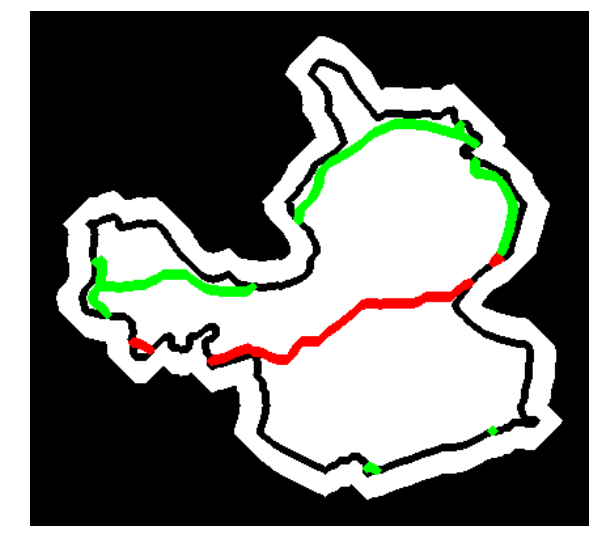

In [53]:
rgb_borders = np.zeros((l_seeds[0].shape[0], l_seeds[0].shape[1], 3), dtype=np.uint8)
rgb_borders[dilated_binary==1] = (255,255,255)
real_border = mh.labeled.border(cropped_binary,0,1)
real_border = mh.dilate(real_border)
real_border = mh.dilate(real_border)
rgb_borders[real_border==1] = (0,0,0)

for i,b in enumerate(l_borders[0:50]):
    rgb_borders[b!=0] = (0,255,0)


rgb_borders[l_borders[GOOD_RESULT]!=0] = (255,0,0)
gp.Util.view(rgb_borders, color=False, large=True, file='/tmp/me_borders.png')


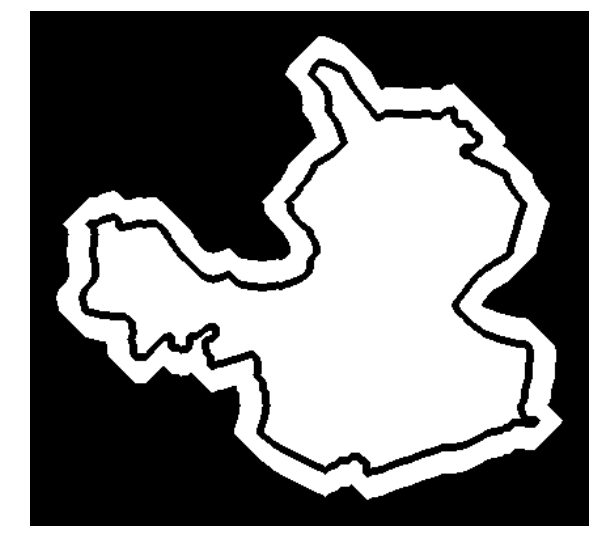

In [54]:
rgb_borders = np.zeros((l_seeds[0].shape[0], l_seeds[0].shape[1], 3), dtype=np.uint8)
rgb_borders[dilated_binary==1] = (255,255,255)
real_border = mh.labeled.border(cropped_binary,0,1)
real_border = mh.dilate(real_border)
real_border = mh.dilate(real_border)
rgb_borders[real_border==1] = (0,0,0)

gp.Util.view(rgb_borders, color=False, large=True, file='/tmp/me_dilated.png')

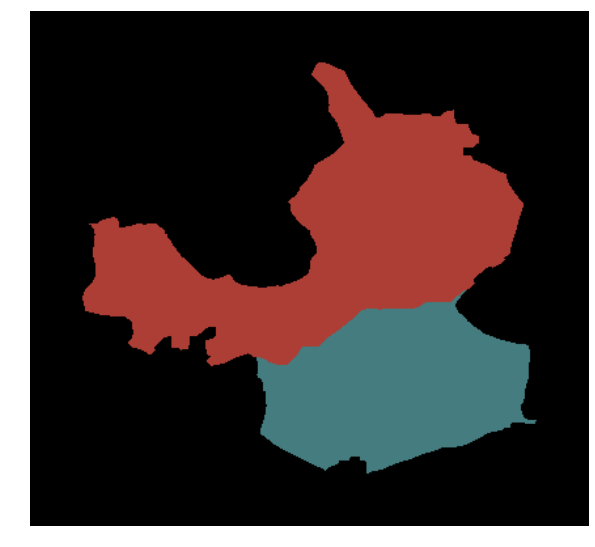

In [72]:
#
# corrected
#
corrected = np.array(cropped_binary)
corrected[l_borders[GOOD_RESULT]!=0] = 0

corrected = gp.Util.relabel(corrected)
corrected[l_borders[GOOD_RESULT]!=0] = corrected[220,220]
corrected[corrected > 2] = 0

corrected[corrected == 1] = cropped_gold[220,220]
corrected[corrected == 2] = cropped_gold[320,280]


gp.Util.view(corrected, color=True, large=True, file='/tmp/me_corrected.png')